In [10]:
import pandas as pd
import numpy as np
import operator
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [11]:
df = pd.read_csv("time_series_covid_19_confirmed.csv", sep=",")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,969,981,989,998,1004,1029,1050,1076,1099,1122
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,762,762,762,763,763,763,763,764,764
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,58,60,61,69,70,70,71,74,81,84


In [12]:

coun=df.set_index('Country/Region').iloc[:,3:-3]
countries=coun.index.drop_duplicates()
coun=coun.T
pak_data=coun['Pakistan']
correlation={}
for country in countries:
    dfr1=coun[country]
    if isinstance(dfr1,pd.core.series.Series):
            x_ax=dfr1
        
    else:
            x_ax=dfr1.sum(axis=1)
    
    corr=np.corrcoef(pak_data,x_ax )
    correlation[country]=corr[0][1]

sort_corr = sorted(correlation.items(), key=operator.itemgetter(1),reverse=True)
selected_countries=['Pakistan']
for i in range(5):
    print(sort_corr[i+1][0],sort_corr[i+1][1])
    selected_countries.append(sort_corr[i+1][0])


Saudi Arabia 0.9989666872972038
Qatar 0.9987397834693383
Colombia 0.9987031556505498
Peru 0.9986075757030275
Egypt 0.9985861314636708


In [13]:
def prepare_data(country,window,string='none'):
    train=[]
    label=[]
    data=[]
    country_data=coun[country]
    prev_cases=0
    for dta in country_data:
        if (dta > 0):
            if string=='rnn':
                data.append([dta-prev_cases])
            else:
                data.append(dta-prev_cases)
            prev_cases=dta
    if (string == 'rnn'):
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
  
    for i in range(len(data)-window-1):
        x = data[i:(i+window)]
        y = data[i+window]
        train.append(x)
        label.append(y)
    if string=='rnn':
        return torch.tensor(train), torch.tensor(label), scaler
    return train,label

In [14]:
def accuracy(y_true,y_pred):
    mse=mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

In [34]:
last_day = -17
window = 5
Future = 31
days=[]
day = 11
pred_days=[]
for i in range(17):
    days.append(day+i)
for i in range(31):
    pred_days.append(i+1)

In [16]:
country_pred={}
month_pred={}
for country in selected_countries:
    clf = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000)
    train,label=prepare_data(country,5)
    trainx = train[:-17]
    labelx = label[:-17]
    clf.fit(trainx,labelx)
    xtest = train[-17:]
    ytest = label[-17:]
    predicted=clf.predict(xtest)
    country_pred[country] = predicted
    print(country,accuracy(ytest,predicted))
    
    
    test_seq = [xtest[-1]]
    preds = []
    for _ in range(Future):
        pred = clf.predict(test_seq)
        preds.append(pred)
        new_seq = np.append(test_seq, pred)
        test_seq = new_seq[1:].reshape(1,window)
        month_pred[country] = preds
        

Pakistan 1660.4869767631421
Saudi Arabia 1568.302660615647
Qatar 991.8547094740653
Colombia 626.1835851832442
Peru 3184.770718499491
Egypt 418.48571554791096


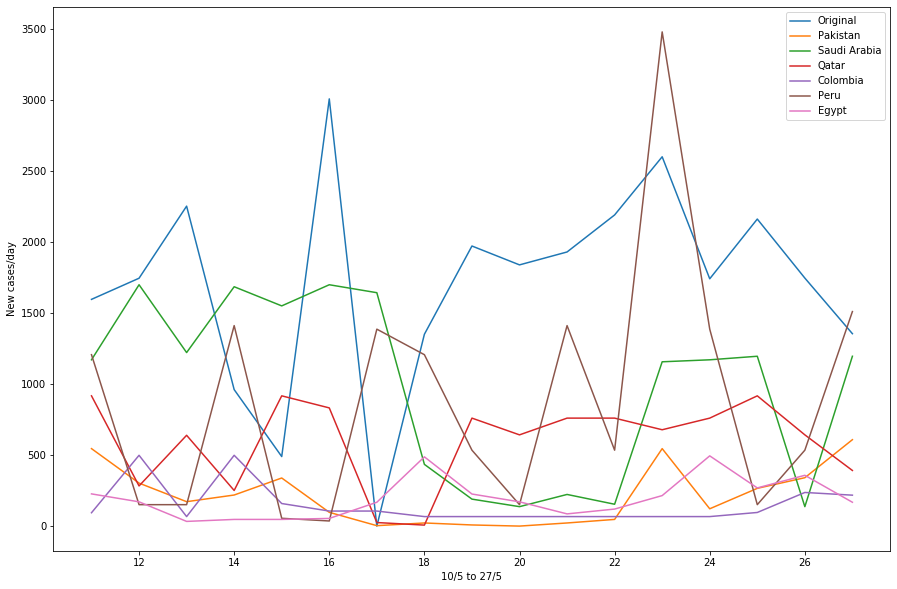

In [17]:
__, pak_label=prepare_data('Pakistan',5)
pak_label = pak_label[-17:]
plt.rcParams['figure.figsize']=(15,10)
plt.plot(days,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(days,country_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

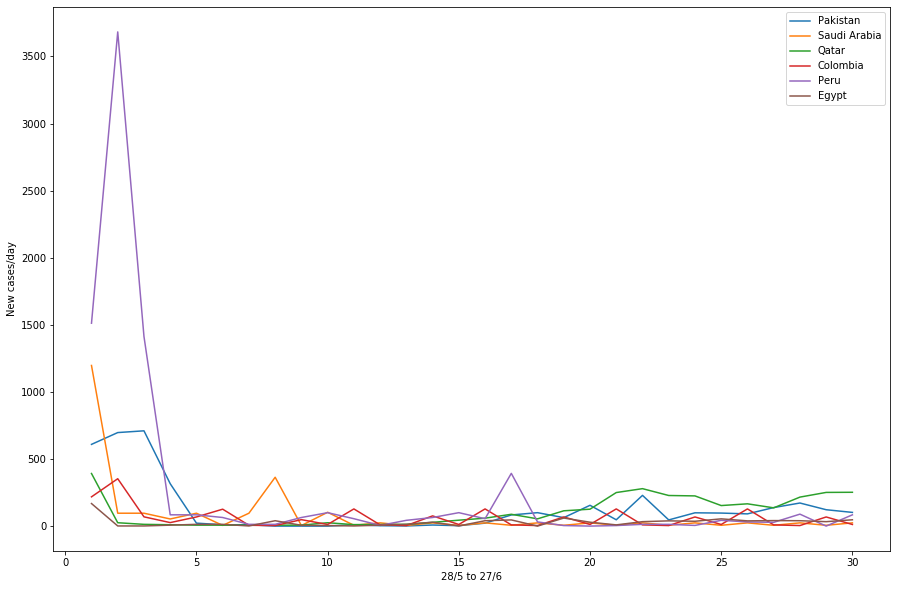

In [24]:
plt.rcParams['figure.figsize']=(15,10)
legend=[]
for data in month_pred:
    plt.plot(pred_days,month_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('28/5 to 27/6')
plt.ylabel('New cases/day')
plt.show()

In [25]:
class RNN(nn.Module):
    def __init__(self, n_layers, n_inputs, n_neurons, n_outputs, seq_length):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.seq_len = seq_length
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons, self.n_layers) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
         
        self.hidden = torch.zeros(self.n_layers, self.seq_len, self.n_neurons)
        
        
    def forward(self, X):
    
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(lstm_out.view(self.seq_len, len(X), self.n_neurons)[-1])
        return out

In [26]:
SEQ_LENGTH = 5
N_STEPS = 3
N_INPUTS = 1
N_NEURONS = 100
N_OUTPUTS = 1

In [82]:
country_predrnn={}
month_predrnn = {}
for country in selected_countries:
    model = RNN(N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS, SEQ_LENGTH)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    trainX,trainy,scaler=prepare_data(country ,5, 'rnn')
    xtrain = trainX[:-17]
    ytrain = trainy[:-17]
    for epoch in range(200): 
        model.train()
        model.hidden = model.init_hidden()
        output = model(xtrain.float())
        loss = criterion(output.float(), ytrain.float())
        if ((epoch+1)%20==0):
            print('Epoch',epoch+1,'Loss',loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    model.eval()
    xtest = trainX[-17:]
    ytest = trainy[-17:]
    output1 = model(xtest.float())
    print(country)
    output1 = np.rint(scaler.inverse_transform(output1.detach().numpy()))
    ytest = scaler.inverse_transform(ytest.detach().numpy())
    country_predrnn[country] = output1
    print('RMSE',accuracy(output1,ytest))
    test_seq = xtrain[-1].reshape(1,window,1)
    preds = []
    for _ in range(Future):
        y_test_pred = model(test_seq.float())
        pred = torch.flatten(y_test_pred).item()
        pred_new = scaler.inverse_transform([[pred]])[0][0]
        
        preds.append(pred_new)
        new_seq = test_seq.numpy()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, window, 1).float()
    preds = np.rint(preds)
    month_predrnn[country] = preds

Epoch 20 Loss 1.78313410282135
Epoch 40 Loss 2.1887764930725098
Epoch 60 Loss 2.3464698791503906
Epoch 80 Loss 2.0788285732269287
Epoch 100 Loss 1.8941230773925781
Epoch 120 Loss 1.8845305442810059
Epoch 140 Loss 1.864197015762329
Epoch 160 Loss 1.732946515083313
Epoch 180 Loss 2.170722246170044
Epoch 200 Loss 1.8930721282958984
Pakistan
RMSE 1497.0906687933884
[394.18986892700195]
[394.18986892700195, 371.61784456670284]
[394.18986892700195, 371.61784456670284, 388.6917733103037]
[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214]
[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214, 341.5854938775301]
[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214, 341.5854938775301, 333.20821256935596]
[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214, 341.5854938775301, 333.20821256935596, 345.185878098011]
[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214,

[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214, 341.5854938775301, 333.20821256935596, 345.185878098011, 350.63215187191963, 342.427610039711, 341.59069849550724, 342.4805535674095, 342.8554655313492, 344.12557178735733, 346.00421454012394, 346.207508713007, 345.945527985692, 347.25238063931465, 347.99053904414177, 347.59934021532536, 347.5000037997961, 347.71693766117096, 347.6053524464369, 347.35463343560696, 347.28423649072647, 347.1870088428259, 347.0075392574072, 346.9322966337204, 346.92094518244267]
[394.18986892700195, 371.61784456670284, 388.6917733103037, 363.40545094013214, 341.5854938775301, 333.20821256935596, 345.185878098011, 350.63215187191963, 342.427610039711, 341.59069849550724, 342.4805535674095, 342.8554655313492, 344.12557178735733, 346.00421454012394, 346.207508713007, 345.945527985692, 347.25238063931465, 347.99053904414177, 347.59934021532536, 347.5000037997961, 347.71693766117096, 347.6053524464369, 347.35463343560696, 347.28423

[322.6787209510803, -68.78841042518616, 273.67479383945465, -65.59409692883492, 306.1172753572464, -55.43242946267128, 292.8558886051178, -64.54239889979362, 296.80546402931213, -59.05156522989273, 296.28362476825714, -61.78707405924797, 295.9084218740463, -60.59484422206879, 296.3355505466461, -61.05073943734169, 296.04583263397217, -60.90502351522446, 296.207492351532, -60.93624457716942, 296.1274242401123, -60.939746499061584, 296.16348028182983, -60.9300871193409]
[322.6787209510803, -68.78841042518616, 273.67479383945465, -65.59409692883492, 306.1172753572464, -55.43242946267128, 292.8558886051178, -64.54239889979362, 296.80546402931213, -59.05156522989273, 296.28362476825714, -61.78707405924797, 295.9084218740463, -60.59484422206879, 296.3355505466461, -61.05073943734169, 296.04583263397217, -60.90502351522446, 296.207492351532, -60.93624457716942, 296.1274242401123, -60.939746499061584, 296.16348028182983, -60.9300871193409, 296.1489224433899]
[322.6787209510803, -68.78841042518

[323.6882494390011, 320.9105072915554, 320.4493045806885, 321.7354255914688, 322.89479970932007, 322.7077880501747, 322.4022647738457, 322.43321523070335, 322.54046469926834, 322.5208854675293, 322.4854901432991, 322.48633548617363, 322.4973249435425, 322.4985247850418, 322.49574333429337, 322.4949797987938, 322.4956615269184, 322.49596148729324, 322.49574333429337]
[323.6882494390011, 320.9105072915554, 320.4493045806885, 321.7354255914688, 322.89479970932007, 322.7077880501747, 322.4022647738457, 322.43321523070335, 322.54046469926834, 322.5208854675293, 322.4854901432991, 322.48633548617363, 322.4973249435425, 322.4985247850418, 322.49574333429337, 322.4949797987938, 322.4956615269184, 322.49596148729324, 322.49574333429337, 322.4957160651684]
[323.6882494390011, 320.9105072915554, 320.4493045806885, 321.7354255914688, 322.89479970932007, 322.7077880501747, 322.4022647738457, 322.43321523070335, 322.54046469926834, 322.5208854675293, 322.4854901432991, 322.48633548617363, 322.497324

[181.60146608948708, 127.82864114642143, 115.63972006738186, 184.15341433882713, 143.99094177782536, 231.6861164867878, 289.6111155152321, 148.74440230429173, 181.5288851559162, 127.78241673856974, 115.64556887000799, 184.2262577712536]
[181.60146608948708, 127.82864114642143, 115.63972006738186, 184.15341433882713, 143.99094177782536, 231.6861164867878, 289.6111155152321, 148.74440230429173, 181.5288851559162, 127.78241673856974, 115.64556887000799, 184.2262577712536, 143.96792390942574]
[181.60146608948708, 127.82864114642143, 115.63972006738186, 184.15341433882713, 143.99094177782536, 231.6861164867878, 289.6111155152321, 148.74440230429173, 181.5288851559162, 127.78241673856974, 115.64556887000799, 184.2262577712536, 143.96792390942574, 231.7014398574829]
[181.60146608948708, 127.82864114642143, 115.63972006738186, 184.15341433882713, 143.99094177782536, 231.6861164867878, 289.6111155152321, 148.74440230429173, 181.5288851559162, 127.78241673856974, 115.64556887000799, 184.22625777

[181.60146608948708, 127.82864114642143, 115.63972006738186, 184.15341433882713, 143.99094177782536, 231.6861164867878, 289.6111155152321, 148.74440230429173, 181.5288851559162, 127.78241673856974, 115.64556887000799, 184.2262577712536, 143.96792390942574, 231.7014398574829, 289.5945452749729, 148.7263883203268, 181.53187108039856, 127.77973432838917, 115.64676652103662, 184.228242918849, 143.9671692252159, 231.70193204283714, 289.59415152668953, 148.7258141040802, 181.53193670511246, 127.77963589131832, 115.64679113030434, 184.22832494974136, 143.96713641285896, 231.7019648551941, 289.5941187143326]
Epoch 20 Loss 2.46893572807312
Epoch 40 Loss 2.7408504486083984
Epoch 60 Loss 2.363403558731079
Epoch 80 Loss 2.368339776992798
Epoch 100 Loss 2.3607399463653564
Epoch 120 Loss 2.35943341255188
Epoch 140 Loss 2.3592581748962402
Epoch 160 Loss 2.359049081802368
Epoch 180 Loss 2.3587992191314697
Epoch 200 Loss 2.3584811687469482
Peru
RMSE 2895.9765903343737
[1084.8945624232292]
[1084.8945624

[1084.8945624232292, 1082.7721255123615, 1081.6293383538723, 1081.7029748558998, 1081.5485491156578, 1081.5916489362717, 1081.57523432374, 1081.5719330608845, 1081.5771600604057, 1081.57569283247, 1081.574959218502, 1081.57569283247, 1081.575326025486, 1081.575326025486, 1081.57569283247, 1081.575509428978, 1081.575601130724, 1081.575417727232, 1081.57523432374, 1081.575326025486, 1081.575142621994, 1081.575326025486, 1081.575326025486, 1081.575326025486, 1081.575509428978, 1081.575601130724, 1081.575509428978]
[1084.8945624232292, 1082.7721255123615, 1081.6293383538723, 1081.7029748558998, 1081.5485491156578, 1081.5916489362717, 1081.57523432374, 1081.5719330608845, 1081.5771600604057, 1081.57569283247, 1081.574959218502, 1081.57569283247, 1081.575326025486, 1081.575326025486, 1081.57569283247, 1081.575509428978, 1081.575601130724, 1081.575417727232, 1081.57523432374, 1081.575326025486, 1081.575142621994, 1081.575326025486, 1081.575326025486, 1081.575326025486, 1081.575509428978, 1081

[179.37728434801102, 121.5176072716713, 73.72274667024612, 65.0480055063963, 78.4267845749855, 116.82192236185074, 169.81473237276077, 117.0861129462719, 70.31290769577026, 63.73722940683365, 78.11929672956467, 116.8528664112091, 169.8048470914364, 117.08946228027344, 70.30024260282516, 63.734591975808144, 78.12072053551674, 116.85559198260307, 169.8051182925701, 117.08973348140717, 70.30013412237167, 63.73455807566643, 78.12074765563011]
[179.37728434801102, 121.5176072716713, 73.72274667024612, 65.0480055063963, 78.4267845749855, 116.82192236185074, 169.81473237276077, 117.0861129462719, 70.31290769577026, 63.73722940683365, 78.11929672956467, 116.8528664112091, 169.8048470914364, 117.08946228027344, 70.30024260282516, 63.734591975808144, 78.12072053551674, 116.85559198260307, 169.8051182925701, 117.08973348140717, 70.30013412237167, 63.73455807566643, 78.12074765563011, 116.85563266277313]
[179.37728434801102, 121.5176072716713, 73.72274667024612, 65.0480055063963, 78.4267845749855,

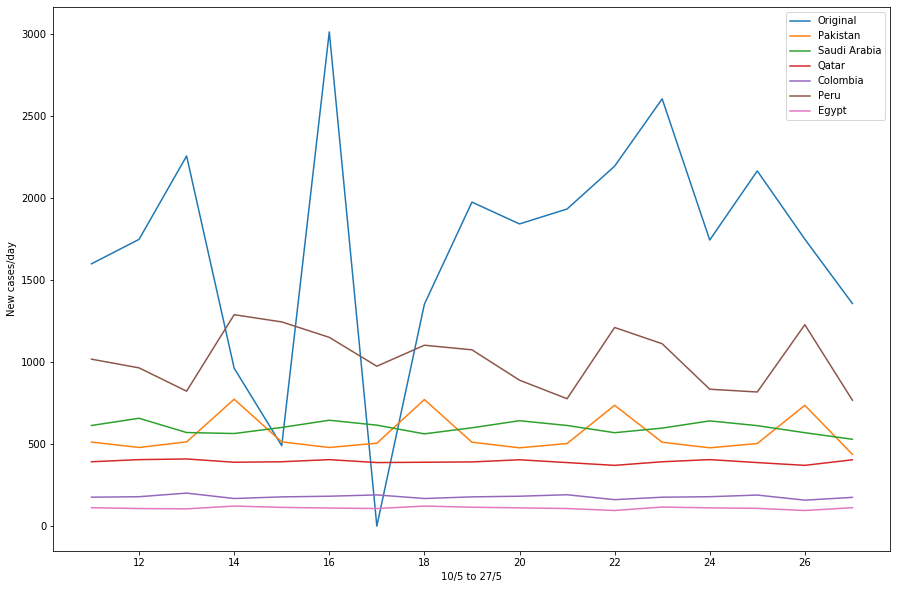

In [80]:
plt.rcParams['figure.figsize']=(15,10)
plt.plot(days,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(days,country_predrnn[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

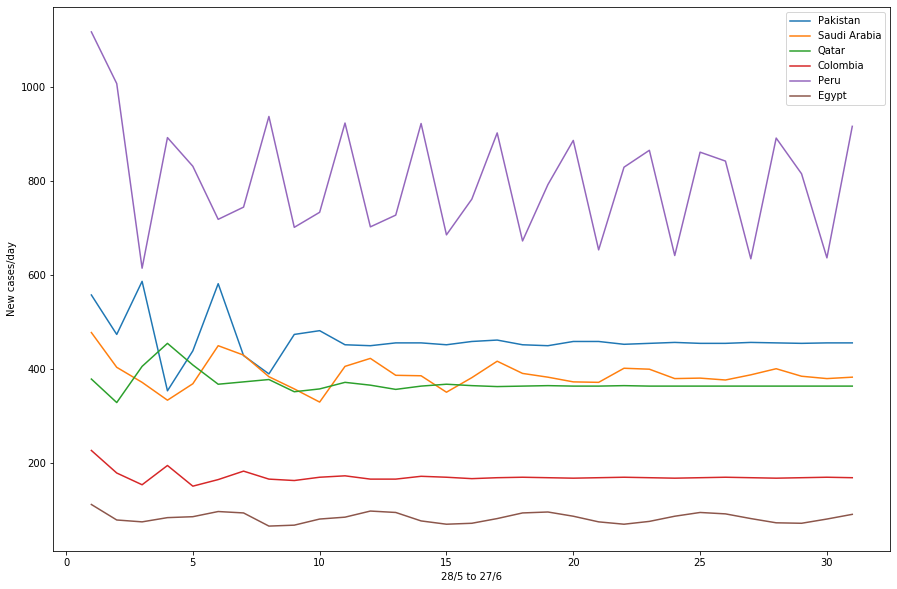

{'Pakistan': array([558., 474., 587., 354., 439., 582., 429., 390., 474., 482., 452.,
       450., 456., 456., 452., 459., 462., 452., 450., 459., 459., 453.,
       455., 457., 455., 455., 457., 456., 455., 456., 456.]), 'Saudi Arabia': array([478., 404., 372., 334., 369., 450., 430., 384., 358., 330., 406.,
       423., 387., 386., 351., 382., 417., 391., 383., 373., 372., 402.,
       400., 380., 381., 377., 388., 401., 385., 380., 383.]), 'Qatar': array([379., 329., 406., 455., 409., 368., 373., 378., 352., 358., 372.,
       366., 357., 364., 368., 365., 363., 364., 365., 364., 364., 365.,
       364., 364., 364., 364., 364., 364., 364., 364., 364.]), 'Colombia': array([227., 179., 154., 195., 151., 165., 183., 166., 163., 170., 173.,
       166., 166., 172., 170., 167., 169., 170., 169., 168., 169., 170.,
       169., 168., 169., 170., 169., 168., 169., 170., 169.]), 'Peru': array([1118., 1008.,  615.,  893.,  832.,  719.,  745.,  938.,  702.,
        734.,  924.,  703.,  728.,  

In [81]:
plt.rcParams['figure.figsize']=(15,10)
legend=[]
for data in month_pred:
    plt.plot(pred_days,month_predrnn[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('28/5 to 27/6')
plt.ylabel('New cases/day')
plt.show()
print(month_predrnn)